## naive 한 모델의 위험성

In [97]:
from sklearn.base import BaseEstimator

class MyDummyClass(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] == 0
            else:
                pred[i] == 1
        return pred

In [98]:
# 위에 내용 계속 다시 실행하기 벅차니까, 정리한번 해두고 넘어가자

# Null 값 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)   
    df['Embarked'].fillna('N', inplace=True)
    return df

# 필요없어보이는 column 삭제
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features=['Sex','Cabin','Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('train.csv')
y = df['Survived']
X = df.drop(['Survived'], axis=1)
X = transform_features(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11)

In [100]:
dummyclf = MyDummyClass()
dummyclf.fit(X_train, y_train)
pred = dummyclf.predict(X_test)

print(f"MyDummyClass의 정확도는: {accuracy_score(y_test, pred):.4f}")

MyDummyClass의 정확도는: 0.6592


### 그냥 대충 성별로만 나눠도 꽤 높은 정확도가 나온다.. 그러니까 accuracy가 능사는 아님

In [101]:
# MNIST에서 가져온 코드
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(f'accuracy: {accuracy:.2f}, 정밀도: {precision:.2f}, 재현율: {recall:.2f}')

In [102]:
import warnings
warnings.filterwarnings('ignore')

# dummy 를 오차행렬과 precision, recall로 확인해보니 확실히 안좋은 모델인걸 볼 수 있다. 
get_clf_eval(y_test, pred)

오차 행렬
[[118   0]
 [ 61   0]]
accuracy: 0.66, 정밀도: 0.00, 재현율: 0.00


## 그렇다면 제대로 된 모델을 사용해서 돌리면 어떨까?

In [103]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train,y_train)

LogisticRegression(solver='liblinear')

In [104]:
# 제대로 값이 나오는걸 볼 수 있다. 
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
accuracy: 0.87, 정밀도: 0.82, 재현율: 0.77


## precision recursion tradeoff...

In [105]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print(f'pred_proba() 결과 shape: {pred_proba.shape}')
print(f'pred_proba array에서 앞 3개만 샘플로 추출: \n{pred_proba[:3]}')

pred_proba_res = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print(f'두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n {pred_proba_res[:3]}')

pred_proba() 결과 shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출: 
[[0.44935229 0.55064771]
 [0.86335514 0.13664486]
 [0.86429646 0.13570354]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.44935229 0.55064771 1.        ]
 [0.86335514 0.13664486 0.        ]
 [0.86429646 0.13570354 0.        ]]


In [106]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]
# Binarizer가 threshold 기준으로 0 혹은 1로 바꿔준다. 
# 이를 활용해서 predict_proba랑 결합할 수 있을거같다.
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [107]:
# shape 변환 확인
pred_proba[:,1].reshape(-1,1)[:3]

array([[0.55064771],
       [0.13664486],
       [0.13570354]])

In [108]:
def threshold_custom(y_test, pred_prob, threshold):
    pred_prob_ = pred_prob[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold = threshold)
    
    custom_pred = binarizer.fit_transform(pred_prob_)
    get_clf_eval(y_test, custom_pred)

In [109]:
# original logistic regression
threshold_custom(y_test, pred_proba, 0.5)

오차 행렬
[[108  10]
 [ 14  47]]
accuracy: 0.87, 정밀도: 0.82, 재현율: 0.77


In [110]:
# 재현율 올라감 -> 암환자 놓치는 빈도 줄어들음
# 정밀도 올라감 -> 모델이 더 신중하게 positive 를 예측함 -> 더 신뢰되는 모델 결과
# threshold 내려감 -> positive로 더 자주 예측함. 
# threshold 올라감 -> positive로 덜 자주 예측함.
threshold_custom(y_test, pred_proba, 0.4)

오차 행렬
[[97 21]
 [11 50]]
accuracy: 0.82, 정밀도: 0.70, 재현율: 0.82


In [111]:
threshold_custom(y_test, pred_proba, 0.6)

오차 행렬
[[113   5]
 [ 17  44]]
accuracy: 0.88, 정밀도: 0.90, 재현율: 0.72


In [112]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for x in thresholds:
        print(f'Current threshold: {x}')
        threshold_custom(y_test, pred_proba_c1, x)
        print()

get_eval_by_threshold(y_test, pred_proba, thresholds)

Current threshold: 0.4
오차 행렬
[[97 21]
 [11 50]]
accuracy: 0.82, 정밀도: 0.70, 재현율: 0.82

Current threshold: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
accuracy: 0.85, 정밀도: 0.79, 재현율: 0.79

Current threshold: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
accuracy: 0.87, 정밀도: 0.82, 재현율: 0.77

Current threshold: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
accuracy: 0.87, 정밀도: 0.87, 재현율: 0.74

Current threshold: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
accuracy: 0.88, 정밀도: 0.90, 재현율: 0.72



In [113]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print(f'반환된 분류 결정 임곗값 배열의 shape: {thresholds.shape}')

# threshold 배열의 크기는 165개이기에, 15를 step size로 총 10개의 임계값을 고른다
thr_idx = np.arange(0, thresholds.shape[0], 15)
print(f'샘플 추출을 위한 임계값 배열의 idx 10개: {thr_idx}')
print(f'샘플용 10개의 임곗값: {np.round(thresholds[thr_idx],2)}')

# 임계값 배열을 활용한 결과 추출
# 임계값이 올라갈수록 정밀도는 올라가고, 재현율은 떨어진다.
print(f'샘플 임계값별 정밀도: {np.round(precision[thr_idx], 3)}')
print(f'샘플 임계값별 재현율: {np.round(recalls[thr_idx], 3)}')

반환된 분류 결정 임곗값 배열의 shape: (165,)
샘플 추출을 위한 임계값 배열의 idx 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


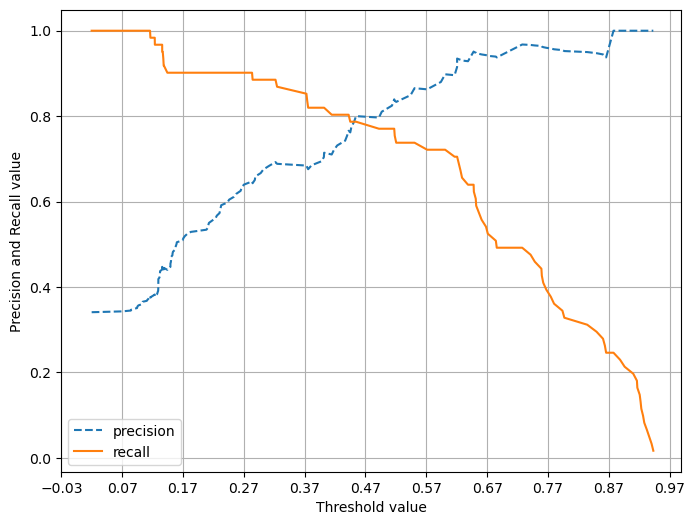

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## 여기까지 오면서 느꼈겠지만, 정밀도와 재현율의 수치가 적절하게 조합 되어 분류의 종합적인 성능평가에 사용될 수 있는 평가 지표가 필요하다 => F1 score

In [115]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print(f'f1 스코어 값: {f1:.4f}')

f1 스코어 값: 0.7966


In [116]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1스코어: {f1:.4f}')
    
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for x in thresholds:
        print(f'Current threshold: {x}')
        threshold_custom(y_test, pred_proba_c1, x)
        print()

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
#threshold_custom(y_test, pred_proba, 0.6)
get_eval_by_threshold(y_test, pred_proba, thresholds)

Current threshold: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, f1스코어: 0.7576

Current threshold: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, f1스코어: 0.7869

Current threshold: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, f1스코어: 0.7966

Current threshold: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, f1스코어: 0.7965

Current threshold: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, f1스코어: 0.8000



## ROC AUC Curve
임계값을 0에서 1까지 변화하면서 FPR을 구하고, 각각 FPR의 변화에 따른 TPR값을 구하고 이를 곡선으로 찍은게 ROC

In [117]:
# ROC -> FPR이 변할때 TPR이 어떻게 변하는지
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 임계값 5 step size로 설정
print(thresholds.shape)
thr_idx = np.arange(1, thresholds.shape[0], 5)

print(f'샘플 추출을 위한 임곗값 배열의 index: {thr_idx}')
print(f'샘플 index로 추출한 임곗값: {np.round(thresholds[thr_idx],2)}')

print(f'샘플 임곗값별 FPR: {np.round(fprs[thr_idx],3)}')
print(f'샘플 임곗값별 TPR: {np.round(tprs[thr_idx],3)}')

(48,)
샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


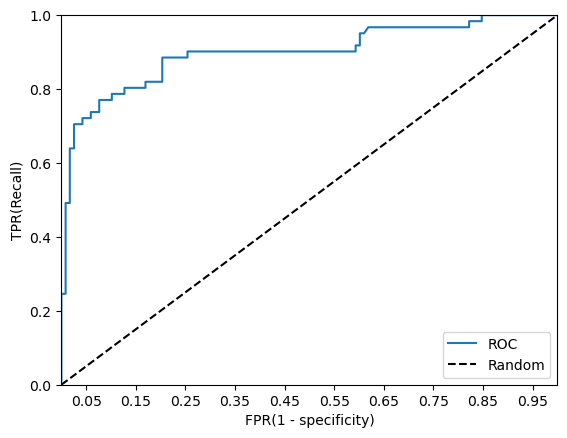

In [121]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - specificity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
roc_curve_plot(y_test, pred_proba_class1)

### ROC 곡선은 FPR과 TPR의 변화 값을 보는데 이용하며 분류의 성능 지표로 사용되는것은 ROC 곡선 면적에 기반한 AUC 값으로 결정한다. 
AUC 곡선은 1에 가까울수록 좋은 수치이며, 이가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 중요하다

In [122]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f'ROC AUC 값: {roc_score:.4f}')

ROC AUC 값: 0.8987


In [123]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1스코어: {f1:.4f}, AUC:{auc:.4f}')